# Influencia de las estrategias de muestreo de puntos de colocación
## TP N°3: Modelado PINN
### Redes Neuronales Informadas por Física - Maestria en Inteligencia Artificial
#### Grupo N°4: Jorge Ceferino Valdez, Fabian Sarmiento y Trinidad Monreal.
---

Buscamos reconstruir el campo de flujo estacionario en una cavidad cuadrada usando una Red Neuronal Informada por Física (PINN). Se trata de resolver las ecuaciones de Navier-Stokes incomprensibles:

$$(\mathbf{u} \cdot \nabla)\mathbf{u} = -\nabla p + \frac{1}{Re} \nabla^2 \mathbf{u} \text{,  en Ω}$$

$$\nabla \cdot \mathbf{u} = 0 \text{,  en Ω}$$

con las siguientes condiciones de borde:

- _No-slip_ en las fronteras laterales e inferior ($\mathbf{u} = (0,0)$)
- Velocidad constante en direccion $+x$ en la frontera superior ($\mathbf{u} = (1,0)$)

y $Ω = [0,1]⊗[0,1]$

In [1]:
!pip install pyDOE

  Using cached pydoe-0.3.8-py3-none-any.whl



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from tqdm import trange

In [4]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from scipy.io import loadmat
from scipy.interpolate import griddata

from IPython.display import clear_output
import time
from datetime import datetime, timedelta
import gc


In [5]:
np.random.seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    device_name = "CUDA GPU"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU (MPS)"
else:
    device = torch.device("cpu")
    device_name = "CPU"

# Configure the seed
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
elif torch.backends.mps.is_available():
    # MPS usa la misma semilla que PyTorch general
    torch.manual_seed(42)

print(f"Usando dispositivo: {device} ({device_name})")

Usando dispositivo: cuda:0 (CUDA GPU)


### 1. Implementación básica de un esquema vanilla PINN para realizar el cómputo “directo” de las variables dependientes en estudio (en este caso, la presión 𝑝 y velocidades 𝑢 y 𝑣) 
_Implementar una rutina que incluya los pasos enumerados previamente. Tomar como referencia las implementaciones provistas por la cátedra (ver notebooks de Colab). Prestar especial atención al cómputo de las derivadas de la presión 𝑝 y velocidades 𝑢 y 𝑣 en función de las variables independientes, y a la construcción de los residuos correspondientes._

### 2. Resolver el sistema de ecuaciones del enunciado mediante PINN, sin emplear datos rotulados.
*Utilizar muestreos aleatorios tanto para el residuo de las PDE como para las condiciones de borde. Utilizar N<sub>pde</sub> = 10000 y N<sub>bc</sub> = 1000*

### Clase PINN Navier-stokes

In [6]:
class PINN_Module(nn.Module):
    """
    Red Neuronal Informada por Física para resolver las ecuaciones de Navier-Stokes
    en una cavidad cuadrada con lid-driven flow
    """
    
    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters["Device"]
        self.LowerBounds = model_parameters["LowerBounds"]
        self.UpperBounds = model_parameters["UpperBounds"]
        self.Re = model_parameters["Re"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        
        # Definir arquitectura de la red
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) 
             for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)
        
        # Inicialización Xavier
        self.init_xavier()

    def forward(self, X):
        """
        Forward pass de la red neuronal
        Input: X tensor de forma (N, 2) con coordenadas (x, y)
        Output: tensor de forma (N, 3) con (u, v, p)
        """
        lb = self.LowerBounds
        ub = self.UpperBounds
        
        # Normalización de entradas a [-1, 1]
        X = 2 * (X - lb) / (ub - lb) - 1
        
        # Forward pass
        output = self.ActivationFunction(self.InputLayer(X))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        
        return output

    def init_xavier(self):
        """Inicialización Xavier mejorada de los pesos"""
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # Bias no cero para romper simetría
                torch.nn.init.uniform_(m.bias, -0.1, 0.1)
        
        self.apply(init_weights)

    def navierstokesResidue(self, X, uvp):
        """
        Calcula los residuos de las ecuaciones de Navier-Stokes
        
        Ecuaciones:
        (u·∇)u = -∇p + (1/Re)∇²u  →  u*∂u/∂x + v*∂u/∂y + ∂p/∂x - (1/Re)(∂²u/∂x² + ∂²u/∂y²) = 0
        (u·∇)v = -∇p + (1/Re)∇²v  →  u*∂v/∂x + v*∂v/∂y + ∂p/∂y - (1/Re)(∂²v/∂x² + ∂²v/∂y²) = 0
        ∇·u = ∂u/∂x + ∂v/∂y = 0
        """
        u = uvp[:, 0:1]  # velocidad en x
        v = uvp[:, 1:2]  # velocidad en y
        p = uvp[:, 2:3]  # presión
        
        Re = self.Re
        
        # Derivadas de primer orden usando autodiferenciación
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        u_x = diff_u[:, 0:1]
        u_y = diff_u[:, 1:2]
        
        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        v_x = diff_v[:, 0:1]
        v_y = diff_v[:, 1:2]
        
        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        p_x = diff_p[:, 0:1]
        p_y = diff_p[:, 1:2]
        
        # Derivadas de segundo orden
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, X, create_graph=True, grad_outputs=torch.ones_like(u_y))[0][:, 1:2]
        
        v_xx = torch.autograd.grad(v_x, X, create_graph=True, grad_outputs=torch.ones_like(v_x))[0][:, 0:1]
        v_yy = torch.autograd.grad(v_y, X, create_graph=True, grad_outputs=torch.ones_like(v_y))[0][:, 1:2]
        
        # Residuos de las ecuaciones de momentum
        residue_u = u * u_x + v * u_y + p_x - (1/Re) * (u_xx + u_yy)
        residue_v = u * v_x + v * v_y + p_y - (1/Re) * (v_xx + v_yy)
        
        # Residuo de continuidad
        residue_continuity = u_x + v_y
        
        return residue_u, residue_v, residue_continuity

#### Configuración del dominio y condiciones de borde

In [7]:
# Parámetros del problema
Re = 100.0  # Número de Reynolds
xi, xf = 0.0, 1.0  # Límites en x
yi, yf = 0.0, 1.0  # Límites en y

# Límites del dominio
lb = torch.tensor([xi, yi], device=device)  # Lower bounds
ub = torch.tensor([xf, yf], device=device)  # Upper bounds

# Condiciones de borde
u_wall = 0.0    # Velocidad en las paredes (no-slip)
v_wall = 0.0    # Velocidad normal en las paredes
u_lid = 1.0     # Velocidad de la tapa superior
v_lid = 0.0     # Velocidad normal en la tapa

print(f"Número de Reynolds: {Re}")
print(f"Dominio: [{xi}, {xf}] x [{yi}, {yf}]")
print(f"Condiciones de borde:")
print(f"  - Paredes laterales e inferior: u=v=0 (no-slip)")
print(f"  - Tapa superior: u={u_lid}, v={v_lid}")

Número de Reynolds: 100.0
Dominio: [0.0, 1.0] x [0.0, 1.0]
Condiciones de borde:
  - Paredes laterales e inferior: u=v=0 (no-slip)
  - Tapa superior: u=1.0, v=0.0


#### Carga de datos de ground-truth

In [8]:
# Cargar datos de los .mat
pressure_mat = loadmat('Re-100/pressure.mat')
velocity_mat = loadmat('Re-100/velocity.mat')

x = pressure_mat['x'].squeeze()
y = pressure_mat['y'].squeeze()
p = pressure_mat['p'].squeeze()
u = velocity_mat['u'].squeeze()
v = velocity_mat['v'].squeeze()

# Reconstruir grilla regular
x_unique = np.linspace(x.min(), x.max(), 201)
y_unique = np.linspace(y.min(), y.max(), 201)
X_grid, Y_grid = np.meshgrid(x_unique, y_unique)

# Interpolar campos sobre la grilla
U_grid = griddata((x, y), u, (X_grid, Y_grid), method='cubic')
V_grid = griddata((x, y), v, (X_grid, Y_grid), method='cubic')
P_grid = griddata((x, y), p, (X_grid, Y_grid), method='cubic')

# Preparar puntos para evaluación del modelo
X_eval = torch.tensor(np.stack([X_grid.flatten(), Y_grid.flatten()], axis=1), dtype=torch.float32, device=device)

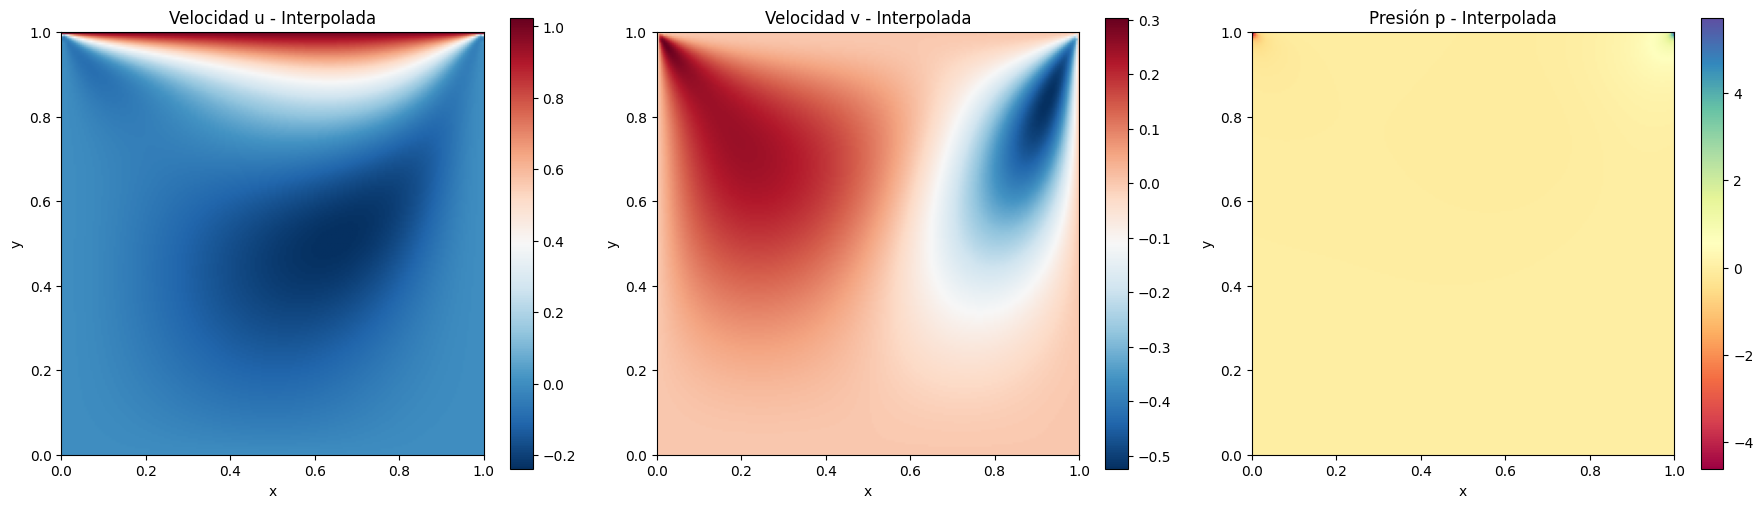

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Campo u
im0 = axs[0].imshow(U_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='RdBu_r', aspect='equal')
axs[0].set_title("Velocidad u - Interpolada")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
plt.colorbar(im0, ax=axs[0])

# Campo v
im1 = axs[1].imshow(V_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='RdBu_r', aspect='equal')
axs[1].set_title("Velocidad v - Interpolada")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.colorbar(im1, ax=axs[1])

# Campo p
im2 = axs[2].imshow(P_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='Spectral', aspect='equal')
axs[2].set_title("Presión p - Interpolada")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

#### Generación de puntos de colocación 

In [10]:
def sample_training_points(N_pde, N_bc, device):
    """
    Genera puntos de colocación para PINNs:
    - Puntos interiores (PDE)
    - Puntos de borde (BC): bottom, top, left, right
    """
    # PDE points en el dominio [0,1] x [0,1]
    pde_points = torch.rand(N_pde, 2, device=device)

    # Puntos de borde
    N_each = N_bc // 4
    rand = torch.rand(N_each, device=device)

    bottom = torch.stack([rand, torch.zeros_like(rand)], dim=1)
    top    = torch.stack([rand, torch.ones_like(rand)], dim=1)
    left   = torch.stack([torch.zeros_like(rand), rand], dim=1)
    right  = torch.stack([torch.ones_like(rand), rand], dim=1)

    bc_points = torch.cat([bottom, top, left, right], dim=0)

    return pde_points, bottom, top, left, right, bc_points

In [11]:
N_pde = 10000
N_bc = 1000

print(f"Generando puntos de colocación:")
pde_points, bottom, top, left, right, bc_points = sample_training_points(N_pde, N_bc, device)
print(f"  - N_pde = {N_pde}")
print(f"  - N_bc = {N_bc} (divididos en 4 bordes)")
print(f"Puntos generados exitosamente")

Generando puntos de colocación:
  - N_pde = 10000
  - N_bc = 1000 (divididos en 4 bordes)
Puntos generados exitosamente


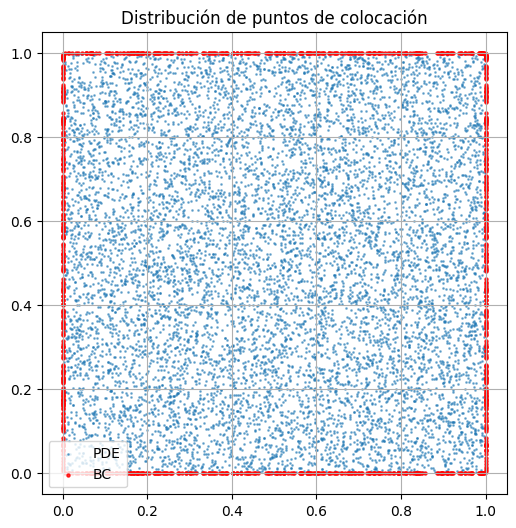

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(pde_points[:,0].cpu(), pde_points[:,1].cpu(), s=1, label='PDE', alpha=0.5)
plt.scatter(bc_points[:,0].cpu(), bc_points[:,1].cpu(), s=5, label='BC', color='red', alpha=0.8)
plt.legend()
plt.title("Distribución de puntos de colocación")
plt.grid(True)
plt.show()

#### Configuración del modelo

In [13]:
# Parámetros del modelo
model_parameters = {
    "Device": device,
    "LowerBounds": lb.to(device),
    "UpperBounds": ub.to(device),
    "Re": Re,
    "InputDimensions": 2,      # (x, y)
    "OutputDimensions": 3,     # (u, v, p)
    "NumberOfNeurons": 64,    # Era 200 - REDUCIDO por CPU
    "NumberOfHiddenLayers": 5, # Era 12 - REDUCIDO por CPU
    "ActivationFunction": nn.Tanh()
}

In [14]:
# Crear modelo
torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)

print("Arquitectura del modelo:")
print(f"  - Entradas: {model_parameters['InputDimensions']} (x, y)")
print(f"  - Salidas: {model_parameters['OutputDimensions']} (u, v, p)")
print(f"  - Capas ocultas: {model_parameters['NumberOfHiddenLayers']}")
print(f"  - Neuronas por capa: {model_parameters['NumberOfNeurons']}")
print(f"  - Función de activación: {model_parameters['ActivationFunction']}")

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  - Total de parámetros entrenables: {total_params}")

Arquitectura del modelo:
  - Entradas: 2 (x, y)
  - Salidas: 3 (u, v, p)
  - Capas ocultas: 5
  - Neuronas por capa: 64
  - Función de activación: Tanh()
  - Total de parámetros entrenables: 17027


### Entrenamiento

In [ ]:
def compute_bc_loss(uvp, u_target, v_target, loss_fn):
    loss_u = loss_fn(uvp[:, 0:1], u_target)
    loss_v = loss_fn(uvp[:, 1:2], v_target)
    return loss_u + loss_v

def train_pinn(model, pde_points, top, bottom, left, right, 
               epochs, optimizer, scheduler,
               weight_pde, initial_weight_bc, final_weight_bc,
               loss_fn=nn.MSELoss()):
    
    # Historial de pérdidas
    loss_train = []
    loss_train_momentum_u = []
    loss_train_momentum_v = []
    loss_train_continuity = []
    loss_train_bc = []
    
    print("Iniciando entrenamiento ...")
    t0 = datetime.now()
    
    for epoch in trange(epochs, desc="Entrenando modelo PINN"):
        progress = epoch / epochs
        current_weight_bc = initial_weight_bc * (1 - progress) + final_weight_bc * progress
        
        model.train()
        optimizer.zero_grad()
        
        # === PDE ===
        pde_points_epoch = pde_points.detach().clone().requires_grad_(True)
        uvp_pde = model(pde_points_epoch)
        res_u, res_v, res_cont = model.navierstokesResidue(pde_points_epoch, uvp_pde)
        
        # Pérdidas PDE (los residuos deben ser cero)
        loss_u = loss_fn(res_u, torch.zeros_like(res_u))
        loss_v = loss_fn(res_v, torch.zeros_like(res_v))
        loss_cont = loss_fn(res_cont, torch.zeros_like(res_cont))
        
        loss_pde_total = loss_u + loss_v + loss_cont
        
        # === BC ===
        uvp_top = model(top)
        uvp_bottom = model(bottom)
        uvp_left = model(left)
        uvp_right = model(right)
        
        loss_bc_top = compute_bc_loss(uvp_top,
                                      torch.ones_like(uvp_top[:, 0:1]),
                                      torch.zeros_like(uvp_top[:, 1:2]),
                                      loss_fn)
        loss_bc_bottom = compute_bc_loss(uvp_bottom,
                                         torch.zeros_like(uvp_bottom[:, 0:1]),
                                         torch.zeros_like(uvp_bottom[:, 1:2]),
                                         loss_fn)
        loss_bc_left = compute_bc_loss(uvp_left,
                                       torch.zeros_like(uvp_left[:, 0:1]),
                                       torch.zeros_like(uvp_left[:, 1:2]),
                                       loss_fn)
        loss_bc_right = compute_bc_loss(uvp_right,
                                        torch.zeros_like(uvp_right[:, 0:1]),
                                        torch.zeros_like(uvp_right[:, 1:2]),
                                        loss_fn)
        
        loss_bc_total = loss_bc_top + loss_bc_bottom + loss_bc_left + loss_bc_right
        loss_total = weight_pde * loss_pde_total + current_weight_bc * loss_bc_total
        
        # Backpropagation
        loss_total.backward()
        optimizer.step()
        scheduler.step()
        
        # Guardar pérdidas
        loss_train.append(loss_total.item())
        loss_train_momentum_u.append(loss_u.item())
        loss_train_momentum_v.append(loss_v.item())
        loss_train_continuity.append(loss_cont.item())
        loss_train_bc.append(loss_bc_total.item())

        # Log del progreso
        if epoch % 500 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                u_top_mean = model(top)[:, 0].mean().item()
            print(f"Epoch {epoch:4d} | Total: {loss_total.item():.2e} | PDE: {loss_pde_total.item():.2e} | "
                  f"BC: {loss_bc_total.item():.2e} | u_top: {u_top_mean:.3f} | lr: {optimizer.param_groups[0]['lr']:.2e}")
    
    elapsed = datetime.now() - t0
    print(f"\nTiempo total: {elapsed.total_seconds():.1f} segundos")

    # Save the model
    torch.save(model.state_dict(), f"models/pinn_trained_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt")
    
    # Retornar historial
    return {
        "total": loss_train,
        "u_momentum": loss_train_momentum_u,
        "v_momentum": loss_train_momentum_v,
        "continuity": loss_train_continuity,
        "bc": loss_train_bc
    }

#### Gráficos de evolución de pérdidas

In [21]:
def plot_losses(loss_dict):
    loss_list = [
        loss_dict["total"],
        loss_dict["u_momentum"],
        loss_dict["v_momentum"],
        loss_dict["continuity"],
        loss_dict["bc"]
    ]
    colors = ['black', 'red', 'green', 'blue', 'magenta']
    titles = ['Overall Loss', 'Momentum U', 'Momentum V', 'Continuity', 'BC']

    fig, ax = plt.subplots(1, len(loss_list), figsize=(25, 4))
    for i, loss in enumerate(loss_list):
        ax[i].loglog(np.arange(len(loss)), loss, color=colors[i])
        ax[i].set_xlabel("Epoch")
        ax[i].set_title(titles[i])
        ax[i].grid(True)
    plt.tight_layout()
    plt.show()

In [22]:
# Verificación final de condiciones de borde
print("\n=== VERIFICACIÓN FINAL DE CONDICIONES DE BORDE ===")
with torch.no_grad():
    # Verificar condición lid-driven
    uvp_top_final = model(top)
    u_top_mean = uvp_top_final[:, 0].mean().item()
    u_top_std = uvp_top_final[:, 0].std().item()
    v_top_mean = uvp_top_final[:, 1].mean().item()
    
    # Verificar condiciones no-slip
    uvp_bottom_final = model(bottom)
    u_bottom_mean = uvp_bottom_final[:, 0].mean().item()
    v_bottom_mean = uvp_bottom_final[:, 1].mean().item()
    
    print(f"Borde superior (lid-driven):")
    print(f"  u: {u_top_mean:.6f} ± {u_top_std:.6f} (objetivo: 1.0)")
    print(f"  v: {v_top_mean:.6f} (objetivo: 0.0)")
    print(f"Borde inferior (no-slip):")
    print(f"  u: {u_bottom_mean:.6f} (objetivo: 0.0)")
    print(f"  v: {v_bottom_mean:.6f} (objetivo: 0.0)")
    
    # Status de convergencia de BC
    if abs(u_top_mean - 1.0) < 0.1:
        print("✓ Condición lid-driven SATISFECHA")
    else:
        print("⚠ Condición lid-driven NO satisfecha")
    
    if abs(u_bottom_mean) < 0.05 and abs(v_bottom_mean) < 0.05:
        print("✓ Condición no-slip SATISFECHA")  
    else:
        print("⚠ Condición no-slip NO satisfecha")



=== VERIFICACIÓN FINAL DE CONDICIONES DE BORDE ===
Borde superior (lid-driven):
  u: 0.983444 ± 0.047871 (objetivo: 1.0)
  v: 0.014180 (objetivo: 0.0)
Borde inferior (no-slip):
  u: -0.000225 (objetivo: 0.0)
  v: 0.001834 (objetivo: 0.0)
✓ Condición lid-driven SATISFECHA
✓ Condición no-slip SATISFECHA


### RAD STRATEGY

#### Train loop

### UNIFORM RANDOM STRATEGY

#### Train loop

### LATIN HYPERCUBE SAMPLING

In [ ]:
from scipy.stats import qmc

n_samples = 100
sampler = qmc.LatinHypercube(d=model_parameters['InputDimensions'])
n_epochs = 100

# Límites del dominio
lb = torch.tensor([xi, yi], device=device)  # Lower bounds
ub = torch.tensor([xf, yf], device=device)  # Upper bounds

In [ ]:
def generate_pde_points_lhs():
        # Generar muestras LHS en [0,1]^2
        lhs_samples_np = sampler.random(n=n_samples)
        lhs_samples_tensor = torch.tensor(lhs_samples_np, dtype=torch.float32)
        
        x_scaled = xi + lhs_samples_tensor[:, 0] * (xf - xi)
        y_scaled = yf + lhs_samples_tensor[:, 1] * (yf - yi)
        
        # Crear tensor
        pde_points = torch.stack([x_scaled, y_scaled], dim=1).float().to(device)
        return pde_points.requires_grad_(True)
    

In [29]:
device = top.device
print(device)

cuda:0


In [30]:
pde_points = generate_pde_points_lhs()

In [31]:

def compute_bc_loss(uvp, u_target, v_target, loss_fn):
    loss_u = loss_fn(uvp[:, 0:1], u_target)
    loss_v = loss_fn(uvp[:, 1:2], v_target)
    return loss_u + loss_v

def train_pinn(model, pde_points, top, bottom, left, right, 
               epochs, optimizer, scheduler,
               weight_pde, initial_weight_bc, final_weight_bc,
               loss_fn=nn.MSELoss(), resample_frequency=100):
    
    # Loss history
    loss_train = []
    loss_train_momentum_u = []
    loss_train_momentum_v = []
    loss_train_continuity = []
    loss_train_bc = []
    
    print(f"Iniciando entrenamiento con LHS:")
    print(f"- Épocas: {epochs}")    
    
    t0 = datetime.now()
    
    for epoch in trange(epochs, desc="Entrenando modelo PINN"):
        if epoch % resample_frequency == 0 and epoch > 0:
            pde_points = generate_pde_points_lhs()
            print(f"\nRe-muestreando puntos PDE en época {epoch}")


        progress = epoch / epochs
        current_weight_bc = initial_weight_bc * (1 - progress) + final_weight_bc * progress
        
        model.train()
        optimizer.zero_grad()
        
        # === PDE ===
        #pde_points_epoch = pde_points.detach().clone().requires_grad_(True)
        pde_points_epoch = pde_points.detach().clone().requires_grad_(True)
        uvp_pde = model(pde_points_epoch)
        res_u, res_v, res_cont = model.navierstokesResidue(pde_points_epoch, uvp_pde)
        
        # Pérdidas PDE (los residuos deben ser cero)
        loss_u = loss_fn(res_u, torch.zeros_like(res_u))
        loss_v = loss_fn(res_v, torch.zeros_like(res_v))
        loss_cont = loss_fn(res_cont, torch.zeros_like(res_cont))
        
        loss_pde_total = loss_u + loss_v + loss_cont
        
        # === BC ===
        uvp_top = model(top)
        uvp_bottom = model(bottom)
        uvp_left = model(left)
        uvp_right = model(right)
        
        loss_bc_top = compute_bc_loss(uvp_top,
                                      torch.ones_like(uvp_top[:, 0:1]),
                                      torch.zeros_like(uvp_top[:, 1:2]),
                                      loss_fn)
        loss_bc_bottom = compute_bc_loss(uvp_bottom,
                                         torch.zeros_like(uvp_bottom[:, 0:1]),
                                         torch.zeros_like(uvp_bottom[:, 1:2]),
                                         loss_fn)
        loss_bc_left = compute_bc_loss(uvp_left,
                                       torch.zeros_like(uvp_left[:, 0:1]),
                                       torch.zeros_like(uvp_left[:, 1:2]),
                                       loss_fn)
        loss_bc_right = compute_bc_loss(uvp_right,
                                        torch.zeros_like(uvp_right[:, 0:1]),
                                        torch.zeros_like(uvp_right[:, 1:2]),
                                        loss_fn)
        
        loss_bc_total = loss_bc_top + loss_bc_bottom + loss_bc_left + loss_bc_right
        loss_total = weight_pde * loss_pde_total + current_weight_bc * loss_bc_total
        
        # Backpropagation
        loss_total.backward()
        optimizer.step()
        scheduler.step()
        
        # Guardar pérdidas
        loss_train.append(loss_total.item())
        loss_train_momentum_u.append(loss_u.item())
        loss_train_momentum_v.append(loss_v.item())
        loss_train_continuity.append(loss_cont.item())
        loss_train_bc.append(loss_bc_total.item())

        # Log del progreso
        if epoch % 500 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                u_top_mean = model(top)[:, 0].mean().item()
            print(f"Epoch {epoch:4d} | Total: {loss_total.item():.2e} | PDE: {loss_pde_total.item():.2e} | "
                  f"BC: {loss_bc_total.item():.2e} | u_top: {u_top_mean:.3f} | lr: {optimizer.param_groups[0]['lr']:.2e}")
            
            resample_info = f" [Re-sampled]" if epoch % resample_frequency == 0 and epoch > 0 else ""
            print(f"Epoch {epoch:4d} | Total: {loss_total.item():.2e} | PDE: {loss_pde_total.item():.2e} | "
                  f"BC: {loss_bc_total.item():.2e} | u_top: {u_top_mean:.3f} | "
                  f"lr: {optimizer.param_groups[0]['lr']:.2e}{resample_info}")
    
    elapsed = datetime.now() - t0
    print(f"\nTiempo total: {elapsed.total_seconds():.1f} segundos")

    # Guardar modelo
    torch.save(model.state_dict(), f"models/pinn_trained_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt")
    
    # Retornar historial
    return {
        "total": loss_train,
        "u_momentum": loss_train_momentum_u,
        "v_momentum": loss_train_momentum_v,
        "continuity": loss_train_continuity,
        "bc": loss_train_bc
    }

In [33]:
import os
os.makedirs("models", exist_ok=True)

Iniciando entrenamiento con LHS:
- Épocas: 10000


Entrenando modelo PINN:   0%|          | 2/10000 [00:00<12:37, 13.19it/s]

Epoch    0 | Total: 6.61e+01 | PDE: 3.72e-01 | BC: 5.77e-03 | u_top: 1.221 | lr: 1.00e-03
Epoch    0 | Total: 6.61e+01 | PDE: 3.72e-01 | BC: 5.77e-03 | u_top: 1.221 | lr: 1.00e-03


Entrenando modelo PINN:   1%|          | 102/10000 [00:06<09:46, 16.88it/s]


Re-muestreando puntos PDE en época 100


Entrenando modelo PINN:   2%|▏         | 202/10000 [00:12<10:42, 15.25it/s]


Re-muestreando puntos PDE en época 200


Entrenando modelo PINN:   3%|▎         | 302/10000 [00:18<10:01, 16.13it/s]


Re-muestreando puntos PDE en época 300


Entrenando modelo PINN:   4%|▍         | 402/10000 [00:24<09:24, 17.00it/s]


Re-muestreando puntos PDE en época 400


Entrenando modelo PINN:   5%|▌         | 502/10000 [00:31<13:35, 11.64it/s]


Re-muestreando puntos PDE en época 500
Epoch  500 | Total: 1.68e+01 | PDE: 4.81e-03 | BC: 3.39e-03 | u_top: 0.996 | lr: 7.78e-04
Epoch  500 | Total: 1.68e+01 | PDE: 4.81e-03 | BC: 3.39e-03 | u_top: 0.996 | lr: 7.78e-04 [Re-sampled]


Entrenando modelo PINN:   6%|▌         | 602/10000 [00:38<11:38, 13.45it/s]


Re-muestreando puntos PDE en época 600


Entrenando modelo PINN:   7%|▋         | 702/10000 [00:44<09:23, 16.49it/s]


Re-muestreando puntos PDE en época 700


Entrenando modelo PINN:   8%|▊         | 802/10000 [00:50<08:55, 17.17it/s]


Re-muestreando puntos PDE en época 800


Entrenando modelo PINN:   9%|▉         | 903/10000 [00:56<08:32, 17.75it/s]


Re-muestreando puntos PDE en época 900


Entrenando modelo PINN:  10%|█         | 1003/10000 [01:02<08:34, 17.49it/s]


Re-muestreando puntos PDE en época 1000
Epoch 1000 | Total: 1.96e+02 | PDE: 2.20e-01 | BC: 3.78e-02 | u_top: 0.959 | lr: 6.06e-04
Epoch 1000 | Total: 1.96e+02 | PDE: 2.20e-01 | BC: 3.78e-02 | u_top: 0.959 | lr: 6.06e-04 [Re-sampled]


Entrenando modelo PINN:  11%|█         | 1103/10000 [01:08<08:32, 17.37it/s]


Re-muestreando puntos PDE en época 1100


Entrenando modelo PINN:  12%|█▏        | 1201/10000 [01:15<12:22, 11.85it/s]


Re-muestreando puntos PDE en época 1200


Entrenando modelo PINN:  13%|█▎        | 1301/10000 [01:24<13:37, 10.64it/s]


Re-muestreando puntos PDE en época 1300


Entrenando modelo PINN:  14%|█▍        | 1401/10000 [01:31<10:15, 13.98it/s]


Re-muestreando puntos PDE en época 1400


Entrenando modelo PINN:  15%|█▌        | 1501/10000 [01:38<09:12, 15.40it/s]


Re-muestreando puntos PDE en época 1500
Epoch 1500 | Total: 1.42e+02 | PDE: 9.14e-02 | BC: 3.01e-02 | u_top: 0.965 | lr: 4.72e-04
Epoch 1500 | Total: 1.42e+02 | PDE: 9.14e-02 | BC: 3.01e-02 | u_top: 0.965 | lr: 4.72e-04 [Re-sampled]


Entrenando modelo PINN:  16%|█▌        | 1603/10000 [01:44<08:14, 16.97it/s]


Re-muestreando puntos PDE en época 1600


Entrenando modelo PINN:  17%|█▋        | 1703/10000 [01:51<08:12, 16.86it/s]


Re-muestreando puntos PDE en época 1700


Entrenando modelo PINN:  18%|█▊        | 1801/10000 [01:57<08:37, 15.85it/s]


Re-muestreando puntos PDE en época 1800


Entrenando modelo PINN:  19%|█▉        | 1903/10000 [02:03<08:23, 16.09it/s]


Re-muestreando puntos PDE en época 1900


Entrenando modelo PINN:  20%|██        | 2003/10000 [02:09<07:46, 17.13it/s]


Re-muestreando puntos PDE en época 2000
Epoch 2000 | Total: 1.15e+02 | PDE: 3.54e-02 | BC: 2.66e-02 | u_top: 0.966 | lr: 3.68e-04
Epoch 2000 | Total: 1.15e+02 | PDE: 3.54e-02 | BC: 2.66e-02 | u_top: 0.966 | lr: 3.68e-04 [Re-sampled]


Entrenando modelo PINN:  21%|██        | 2101/10000 [02:15<07:47, 16.90it/s]


Re-muestreando puntos PDE en época 2100


Entrenando modelo PINN:  22%|██▏       | 2201/10000 [02:21<08:04, 16.10it/s]


Re-muestreando puntos PDE en época 2200


Entrenando modelo PINN:  23%|██▎       | 2301/10000 [02:27<07:59, 16.05it/s]


Re-muestreando puntos PDE en época 2300


Entrenando modelo PINN:  24%|██▍       | 2403/10000 [02:33<07:19, 17.30it/s]


Re-muestreando puntos PDE en época 2400


Entrenando modelo PINN:  25%|██▌       | 2501/10000 [02:40<10:00, 12.49it/s]


Re-muestreando puntos PDE en época 2500
Epoch 2500 | Total: 8.98e+01 | PDE: 2.23e-02 | BC: 2.19e-02 | u_top: 0.976 | lr: 2.86e-04
Epoch 2500 | Total: 8.98e+01 | PDE: 2.23e-02 | BC: 2.19e-02 | u_top: 0.976 | lr: 2.86e-04 [Re-sampled]


Entrenando modelo PINN:  26%|██▌       | 2602/10000 [02:49<10:19, 11.94it/s]


Re-muestreando puntos PDE en época 2600


Entrenando modelo PINN:  27%|██▋       | 2702/10000 [02:56<08:12, 14.83it/s]


Re-muestreando puntos PDE en época 2700


Entrenando modelo PINN:  28%|██▊       | 2802/10000 [03:05<12:06,  9.90it/s]


Re-muestreando puntos PDE en época 2800


Entrenando modelo PINN:  29%|██▉       | 2902/10000 [03:14<07:40, 15.42it/s]


Re-muestreando puntos PDE en época 2900


Entrenando modelo PINN:  30%|███       | 3002/10000 [03:21<10:23, 11.23it/s]


Re-muestreando puntos PDE en época 3000
Epoch 3000 | Total: 7.48e+01 | PDE: 1.46e-02 | BC: 1.93e-02 | u_top: 0.979 | lr: 2.23e-04
Epoch 3000 | Total: 7.48e+01 | PDE: 1.46e-02 | BC: 1.93e-02 | u_top: 0.979 | lr: 2.23e-04 [Re-sampled]


Entrenando modelo PINN:  31%|███       | 3100/10000 [03:30<07:49, 14.71it/s]


Re-muestreando puntos PDE en época 3100


Entrenando modelo PINN:  32%|███▏      | 3202/10000 [03:36<06:50, 16.55it/s]


Re-muestreando puntos PDE en época 3200


Entrenando modelo PINN:  33%|███▎      | 3302/10000 [03:42<06:34, 16.99it/s]


Re-muestreando puntos PDE en época 3300


Entrenando modelo PINN:  34%|███▍      | 3402/10000 [03:48<06:34, 16.71it/s]


Re-muestreando puntos PDE en época 3400


Entrenando modelo PINN:  35%|███▌      | 3503/10000 [03:56<07:02, 15.37it/s]


Re-muestreando puntos PDE en época 3500
Epoch 3500 | Total: 6.87e+01 | PDE: 4.20e-02 | BC: 1.79e-02 | u_top: 0.981 | lr: 1.74e-04
Epoch 3500 | Total: 6.87e+01 | PDE: 4.20e-02 | BC: 1.79e-02 | u_top: 0.981 | lr: 1.74e-04 [Re-sampled]


Entrenando modelo PINN:  36%|███▌      | 3603/10000 [04:02<06:15, 17.04it/s]


Re-muestreando puntos PDE en época 3600


Entrenando modelo PINN:  37%|███▋      | 3703/10000 [04:08<06:15, 16.77it/s]


Re-muestreando puntos PDE en época 3700


Entrenando modelo PINN:  38%|███▊      | 3801/10000 [04:14<06:22, 16.19it/s]


Re-muestreando puntos PDE en época 3800


Entrenando modelo PINN:  39%|███▉      | 3903/10000 [04:21<06:30, 15.63it/s]


Re-muestreando puntos PDE en época 3900


Entrenando modelo PINN:  40%|████      | 4001/10000 [04:27<08:51, 11.30it/s]


Re-muestreando puntos PDE en época 4000
Epoch 4000 | Total: 5.88e+01 | PDE: 3.75e-02 | BC: 1.62e-02 | u_top: 0.982 | lr: 1.35e-04
Epoch 4000 | Total: 5.88e+01 | PDE: 3.75e-02 | BC: 1.62e-02 | u_top: 0.982 | lr: 1.35e-04 [Re-sampled]


Entrenando modelo PINN:  41%|████      | 4101/10000 [04:35<07:11, 13.67it/s]


Re-muestreando puntos PDE en época 4100


Entrenando modelo PINN:  42%|████▏     | 4203/10000 [04:42<06:10, 15.63it/s]


Re-muestreando puntos PDE en época 4200


Entrenando modelo PINN:  43%|████▎     | 4301/10000 [04:48<06:12, 15.30it/s]


Re-muestreando puntos PDE en época 4300


Entrenando modelo PINN:  44%|████▍     | 4403/10000 [04:55<05:37, 16.56it/s]


Re-muestreando puntos PDE en época 4400


Entrenando modelo PINN:  45%|████▌     | 4501/10000 [05:01<06:45, 13.55it/s]


Re-muestreando puntos PDE en época 4500
Epoch 4500 | Total: 5.17e+01 | PDE: 1.77e-02 | BC: 1.56e-02 | u_top: 0.983 | lr: 1.05e-04
Epoch 4500 | Total: 5.17e+01 | PDE: 1.77e-02 | BC: 1.56e-02 | u_top: 0.983 | lr: 1.05e-04 [Re-sampled]


Entrenando modelo PINN:  46%|████▌     | 4601/10000 [05:09<05:26, 16.55it/s]


Re-muestreando puntos PDE en época 4600


Entrenando modelo PINN:  47%|████▋     | 4703/10000 [05:15<05:11, 17.02it/s]


Re-muestreando puntos PDE en época 4700


Entrenando modelo PINN:  48%|████▊     | 4803/10000 [05:21<05:13, 16.59it/s]


Re-muestreando puntos PDE en época 4800


Entrenando modelo PINN:  49%|████▉     | 4901/10000 [05:27<04:58, 17.06it/s]


Re-muestreando puntos PDE en época 4900


Entrenando modelo PINN:  50%|█████     | 5003/10000 [05:33<04:48, 17.29it/s]


Re-muestreando puntos PDE en época 5000
Epoch 5000 | Total: 1.14e+02 | PDE: 7.11e-01 | BC: 1.44e-02 | u_top: 0.985 | lr: 8.20e-05
Epoch 5000 | Total: 1.14e+02 | PDE: 7.11e-01 | BC: 1.44e-02 | u_top: 0.985 | lr: 8.20e-05 [Re-sampled]


Entrenando modelo PINN:  51%|█████     | 5101/10000 [05:40<05:27, 14.96it/s]


Re-muestreando puntos PDE en época 5100


Entrenando modelo PINN:  52%|█████▏    | 5203/10000 [05:46<04:42, 16.95it/s]


Re-muestreando puntos PDE en época 5200


Entrenando modelo PINN:  53%|█████▎    | 5301/10000 [05:53<08:04,  9.70it/s]


Re-muestreando puntos PDE en época 5300


Entrenando modelo PINN:  54%|█████▍    | 5403/10000 [05:59<04:40, 16.37it/s]


Re-muestreando puntos PDE en época 5400


Entrenando modelo PINN:  55%|█████▌    | 5501/10000 [06:05<04:34, 16.42it/s]


Re-muestreando puntos PDE en época 5500
Epoch 5500 | Total: 6.74e+01 | PDE: 6.24e-02 | BC: 2.19e-02 | u_top: 0.971 | lr: 6.39e-05
Epoch 5500 | Total: 6.74e+01 | PDE: 6.24e-02 | BC: 2.19e-02 | u_top: 0.971 | lr: 6.39e-05 [Re-sampled]


Entrenando modelo PINN:  56%|█████▌    | 5603/10000 [06:12<04:16, 17.15it/s]


Re-muestreando puntos PDE en época 5600


Entrenando modelo PINN:  57%|█████▋    | 5701/10000 [06:18<04:06, 17.43it/s]


Re-muestreando puntos PDE en época 5700


Entrenando modelo PINN:  58%|█████▊    | 5803/10000 [06:23<03:55, 17.80it/s]


Re-muestreando puntos PDE en época 5800


Entrenando modelo PINN:  59%|█████▉    | 5901/10000 [06:29<04:04, 16.73it/s]


Re-muestreando puntos PDE en época 5900


Entrenando modelo PINN:  60%|██████    | 6001/10000 [06:35<04:11, 15.90it/s]


Re-muestreando puntos PDE en época 6000
Epoch 6000 | Total: 3.57e+01 | PDE: 9.33e-03 | BC: 1.34e-02 | u_top: 0.985 | lr: 4.97e-05
Epoch 6000 | Total: 3.57e+01 | PDE: 9.33e-03 | BC: 1.34e-02 | u_top: 0.985 | lr: 4.97e-05 [Re-sampled]


Entrenando modelo PINN:  61%|██████    | 6101/10000 [06:41<04:29, 14.46it/s]


Re-muestreando puntos PDE en época 6100


Entrenando modelo PINN:  62%|██████▏   | 6201/10000 [06:49<04:46, 13.25it/s]


Re-muestreando puntos PDE en época 6200


Entrenando modelo PINN:  63%|██████▎   | 6303/10000 [06:57<03:40, 16.73it/s]


Re-muestreando puntos PDE en época 6300


Entrenando modelo PINN:  64%|██████▍   | 6403/10000 [07:04<03:52, 15.46it/s]


Re-muestreando puntos PDE en época 6400


Entrenando modelo PINN:  65%|██████▌   | 6501/10000 [07:09<03:32, 16.43it/s]


Re-muestreando puntos PDE en época 6500
Epoch 6500 | Total: 4.92e+01 | PDE: 1.76e-01 | BC: 1.31e-02 | u_top: 0.986 | lr: 3.87e-05
Epoch 6500 | Total: 4.92e+01 | PDE: 1.76e-01 | BC: 1.31e-02 | u_top: 0.986 | lr: 3.87e-05 [Re-sampled]


Entrenando modelo PINN:  66%|██████▌   | 6601/10000 [07:17<05:30, 10.29it/s]


Re-muestreando puntos PDE en época 6600


Entrenando modelo PINN:  67%|██████▋   | 6703/10000 [07:23<03:17, 16.66it/s]


Re-muestreando puntos PDE en época 6700


Entrenando modelo PINN:  68%|██████▊   | 6801/10000 [07:30<03:32, 15.05it/s]


Re-muestreando puntos PDE en época 6800


Entrenando modelo PINN:  69%|██████▉   | 6901/10000 [07:36<03:08, 16.41it/s]


Re-muestreando puntos PDE en época 6900


Entrenando modelo PINN:  70%|███████   | 7001/10000 [07:42<03:24, 14.69it/s]


Re-muestreando puntos PDE en época 7000
Epoch 7000 | Total: 2.85e+01 | PDE: 1.27e-02 | BC: 1.24e-02 | u_top: 0.986 | lr: 3.02e-05
Epoch 7000 | Total: 2.85e+01 | PDE: 1.27e-02 | BC: 1.24e-02 | u_top: 0.986 | lr: 3.02e-05 [Re-sampled]


Entrenando modelo PINN:  71%|███████   | 7103/10000 [07:49<02:51, 16.90it/s]


Re-muestreando puntos PDE en época 7100


Entrenando modelo PINN:  72%|███████▏  | 7201/10000 [07:56<02:52, 16.20it/s]


Re-muestreando puntos PDE en época 7200


Entrenando modelo PINN:  73%|███████▎  | 7301/10000 [08:02<03:34, 12.61it/s]


Re-muestreando puntos PDE en época 7300


Entrenando modelo PINN:  74%|███████▍  | 7401/10000 [08:09<03:08, 13.79it/s]


Re-muestreando puntos PDE en época 7400


Entrenando modelo PINN:  75%|███████▌  | 7501/10000 [08:16<02:38, 15.77it/s]


Re-muestreando puntos PDE en época 7500
Epoch 7500 | Total: 2.42e+01 | PDE: 7.26e-03 | BC: 1.17e-02 | u_top: 0.987 | lr: 2.35e-05
Epoch 7500 | Total: 2.42e+01 | PDE: 7.26e-03 | BC: 1.17e-02 | u_top: 0.987 | lr: 2.35e-05 [Re-sampled]


Entrenando modelo PINN:  76%|███████▌  | 7603/10000 [08:23<02:46, 14.40it/s]


Re-muestreando puntos PDE en época 7600


Entrenando modelo PINN:  77%|███████▋  | 7701/10000 [08:31<03:20, 11.45it/s]


Re-muestreando puntos PDE en época 7700


Entrenando modelo PINN:  78%|███████▊  | 7801/10000 [08:37<02:13, 16.47it/s]


Re-muestreando puntos PDE en época 7800


Entrenando modelo PINN:  79%|███████▉  | 7901/10000 [08:44<02:19, 15.00it/s]


Re-muestreando puntos PDE en época 7900


Entrenando modelo PINN:  80%|████████  | 8001/10000 [08:50<02:11, 15.24it/s]


Re-muestreando puntos PDE en época 8000
Epoch 8000 | Total: 2.14e+01 | PDE: 9.48e-03 | BC: 1.14e-02 | u_top: 0.987 | lr: 1.83e-05
Epoch 8000 | Total: 2.14e+01 | PDE: 9.48e-03 | BC: 1.14e-02 | u_top: 0.987 | lr: 1.83e-05 [Re-sampled]


Entrenando modelo PINN:  81%|████████  | 8101/10000 [08:57<02:33, 12.35it/s]


Re-muestreando puntos PDE en época 8100


Entrenando modelo PINN:  82%|████████▏ | 8201/10000 [09:04<01:51, 16.13it/s]


Re-muestreando puntos PDE en época 8200


Entrenando modelo PINN:  83%|████████▎ | 8301/10000 [09:10<01:58, 14.31it/s]


Re-muestreando puntos PDE en época 8300


Entrenando modelo PINN:  84%|████████▍ | 8403/10000 [09:17<01:40, 15.88it/s]


Re-muestreando puntos PDE en época 8400


Entrenando modelo PINN:  85%|████████▌ | 8501/10000 [09:24<01:42, 14.60it/s]


Re-muestreando puntos PDE en época 8500
Epoch 8500 | Total: 1.95e+01 | PDE: 5.85e-03 | BC: 1.18e-02 | u_top: 0.987 | lr: 1.42e-05
Epoch 8500 | Total: 1.95e+01 | PDE: 5.85e-03 | BC: 1.18e-02 | u_top: 0.987 | lr: 1.42e-05 [Re-sampled]


Entrenando modelo PINN:  86%|████████▌ | 8601/10000 [09:30<01:22, 16.87it/s]


Re-muestreando puntos PDE en época 8600


Entrenando modelo PINN:  87%|████████▋ | 8703/10000 [09:36<01:16, 16.94it/s]


Re-muestreando puntos PDE en época 8700


Entrenando modelo PINN:  88%|████████▊ | 8801/10000 [09:42<01:09, 17.16it/s]


Re-muestreando puntos PDE en época 8800


Entrenando modelo PINN:  89%|████████▉ | 8903/10000 [09:48<01:04, 17.08it/s]


Re-muestreando puntos PDE en época 8900


Entrenando modelo PINN:  90%|█████████ | 9003/10000 [09:53<00:54, 18.40it/s]


Re-muestreando puntos PDE en época 9000
Epoch 9000 | Total: 1.81e+01 | PDE: 2.02e-02 | BC: 1.15e-02 | u_top: 0.988 | lr: 1.11e-05
Epoch 9000 | Total: 1.81e+01 | PDE: 2.02e-02 | BC: 1.15e-02 | u_top: 0.988 | lr: 1.11e-05 [Re-sampled]


Entrenando modelo PINN:  91%|█████████ | 9103/10000 [09:59<00:52, 17.07it/s]


Re-muestreando puntos PDE en época 9100


Entrenando modelo PINN:  92%|█████████▏| 9203/10000 [10:05<00:46, 17.19it/s]


Re-muestreando puntos PDE en época 9200


Entrenando modelo PINN:  93%|█████████▎| 9303/10000 [10:11<00:42, 16.41it/s]


Re-muestreando puntos PDE en época 9300


Entrenando modelo PINN:  94%|█████████▍| 9402/10000 [10:16<00:34, 17.26it/s]


Re-muestreando puntos PDE en época 9400


Entrenando modelo PINN:  95%|█████████▌| 9503/10000 [10:23<00:29, 17.03it/s]


Re-muestreando puntos PDE en época 9500
Epoch 9500 | Total: 1.39e+01 | PDE: 5.46e-03 | BC: 1.11e-02 | u_top: 0.987 | lr: 8.64e-06
Epoch 9500 | Total: 1.39e+01 | PDE: 5.46e-03 | BC: 1.11e-02 | u_top: 0.987 | lr: 8.64e-06 [Re-sampled]


Entrenando modelo PINN:  96%|█████████▌| 9601/10000 [10:29<00:24, 16.49it/s]


Re-muestreando puntos PDE en época 9600


Entrenando modelo PINN:  97%|█████████▋| 9703/10000 [10:35<00:17, 17.00it/s]


Re-muestreando puntos PDE en época 9700


Entrenando modelo PINN:  98%|█████████▊| 9803/10000 [10:40<00:10, 19.13it/s]


Re-muestreando puntos PDE en época 9800


Entrenando modelo PINN:  99%|█████████▉| 9902/10000 [10:46<00:05, 17.97it/s]


Re-muestreando puntos PDE en época 9900


Entrenando modelo PINN: 100%|██████████| 10000/10000 [10:51<00:00, 15.34it/s]


Epoch 9999 | Total: 1.17e+01 | PDE: 6.48e-03 | BC: 1.11e-02 | u_top: 0.987 | lr: 6.73e-06
Epoch 9999 | Total: 1.17e+01 | PDE: 6.48e-03 | BC: 1.11e-02 | u_top: 0.987 | lr: 6.73e-06

Tiempo total: 651.9 segundos


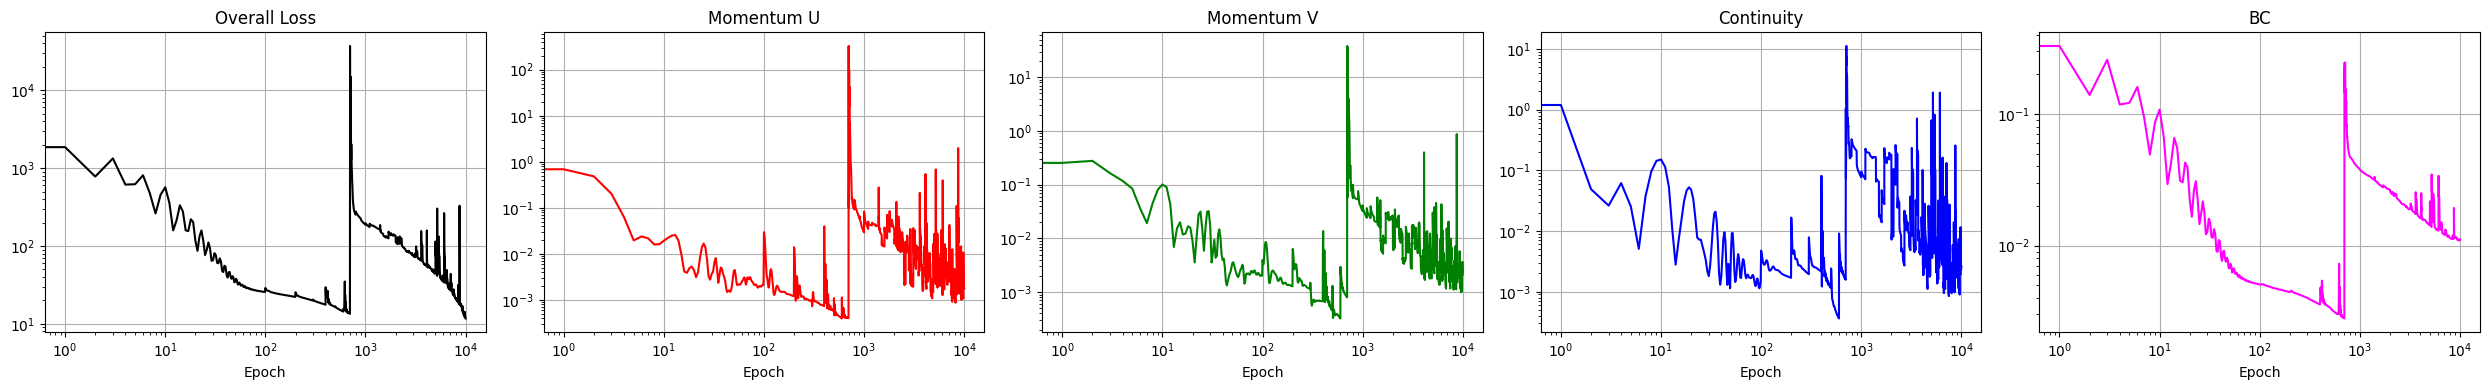

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9995)  # Decay gradual

losses = train_pinn(model, pde_points, top, bottom, left, right,
                    epochs=10000,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    weight_pde=100.0,
                    initial_weight_bc=5000.0,
                    final_weight_bc=1000.0)

plot_losses(losses)